In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from encoding_information.datasets import BSCCMDataset, MNISTDataset
import jax.numpy as np

from cleanplots import *

2024-09-22 09:24:13.024711: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 09:24:14.249833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-22 09:24:14.250043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-09-22 09:24:14.250052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(132, 128, 4)
(132, 128, 4)
(132, 128, 4)


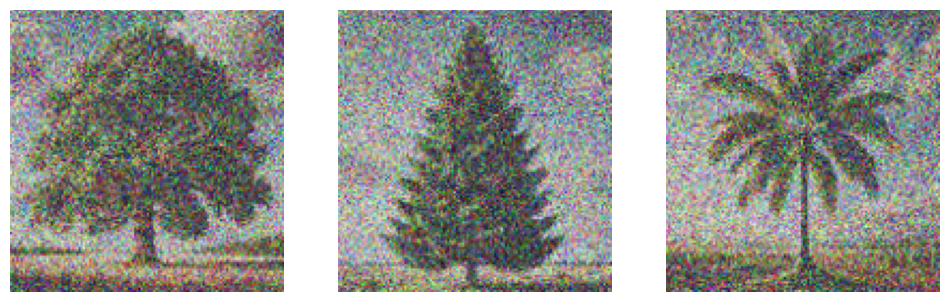

In [2]:
# load 3 files '/home/hpinkard_waller/data/tree1.png'
# load them as numpy arrays

# now load them
from PIL import Image

path = '/home/hpinkard_waller/data/trees/'

images = []
for name in ['tree1.png', 'tree2.png', 'tree3.png']:
    img = Image.open(path + name)
    # resize to 128 x 132
    img = img.resize((128, 132))
    img = np.array(img)
    images.append(img)
    print(img.shape)

# plot them
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for ax, img in zip(axs, images):
    ax.imshow(img)
    ax.axis('off')

images = np.array(images)

In [9]:
from encoding_information import extract_patches

patch_size = 64
num_patches = 10000

patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=True).astype(np.float32)

100%|██████████| 10000/10000 [00:32<00:00, 307.64it/s]


In [10]:
from encoding_information.models import PixelCNN, FullGaussianProcess, StationaryGaussianProcess 

num_samples = 8

gp = FullGaussianProcess(patches)
gp_samples = gp.generate_samples(num_samples=num_samples)

# Cant do PCNN because current implementation is for single channel images
# pixel_cnn = PixelCNN()
# pixel_cnn.fit(patches)
# pixel_cnn_samples = pixel_cnn.generate_samples(num_samples=num_samples)

trying eigenvalue floor of 0.01


/2tb_nvme/hpinkard_waller/GitRepos/EncodingInformation/src/encoding_information/models/gaussian_process.py:695: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.1


/2tb_nvme/hpinkard_waller/GitRepos/EncodingInformation/src/encoding_information/models/gaussian_process.py:695: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.1
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 1.0


/2tb_nvme/hpinkard_waller/GitRepos/EncodingInformation/src/encoding_information/models/gaussian_process.py:695: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 1.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 10.0


In [13]:
sample.max()

Array(295.1486, dtype=float32)

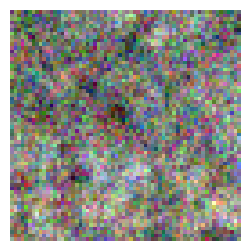

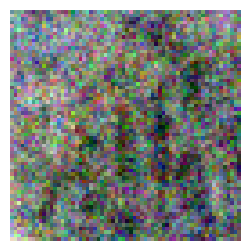

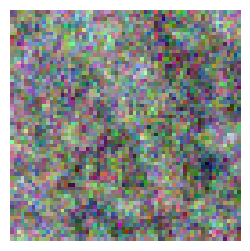

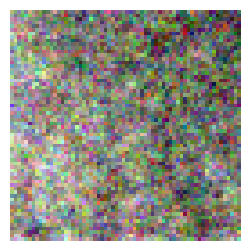

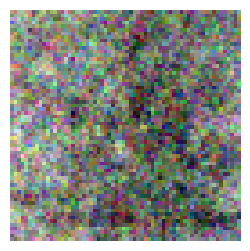

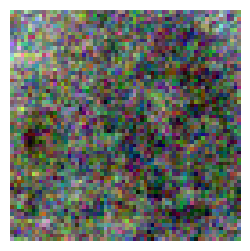

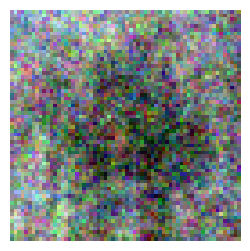

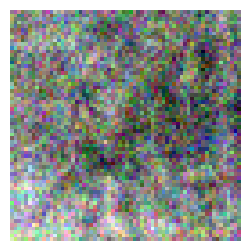

In [14]:
# plot some samples

# save the samples as uncompressed pngs
for i, sample in enumerate(gp_samples):
    fig, ax = plt.subplots(figsize=(3, 3))
    rescaled = np.clip(sample, 0, 255) / 255
    ax.imshow(rescaled, interpolation='nearest')
    ax.axis('off')
    plt.imsave(f'/home/hpinkard_waller/figures/tree_samples/full_gaussian_sample_{i}.pdf', rescaled)


In [16]:
# Make Black dots that jump around GIF


from PIL import Image, ImageDraw
import numpy as np
import os

def create_gaussian_dot_animation(
    num_frames=30,
    image_size=(500, 500),
    dot_radius=40,
    output_folder='/home/hpinkard_waller/figures/black_dot/',
    output_format='PNG'
):
    """
    Generates frames of a black dot moving according to a 2D Gaussian distribution.

    Parameters:
    - num_frames (int): Number of frames to generate.
    - image_size (tuple): Size of the image (width, height).
    - dot_radius (int): Radius of the black dot.
    - output_folder (str): Folder to save the frames.
    - output_format (str): Image format to save frames ('PNG' recommended for transparency).
    """

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Parameters for the Gaussian distribution
    mean_x = image_size[0] / 2
    mean_y = image_size[1] / 2
    std_dev_x = image_size[0] / 6  # Adjust as needed
    std_dev_y = image_size[1] / 6  # Adjust as needed

    for i in range(num_frames):
        # Generate random position according to 2D Gaussian distribution
        x = np.random.normal(loc=mean_x, scale=std_dev_x)
        y = np.random.normal(loc=mean_y, scale=std_dev_y)

        # Ensure the dot stays within the image boundaries
        x = max(dot_radius, min(image_size[0] - dot_radius, x))
        y = max(dot_radius, min(image_size[1] - dot_radius, y))

        # Create a transparent image
        frame = Image.new('RGBA', image_size, (255, 255, 255, 0))
        draw = ImageDraw.Draw(frame)

        # Draw the black circular dot
        left_up_point = (x - dot_radius, y - dot_radius)
        right_down_point = (x + dot_radius, y + dot_radius)
        draw.ellipse([left_up_point, right_down_point], fill='#5FBD3C')

        # Save the frame
        frame.save(
            os.path.join(output_folder, f'frame_{i:03d}.{output_format.lower()}'),
            format=output_format
        )

# Example usage
create_gaussian_dot_animation()


In [17]:
!convert -delay 3.33 -loop 0 -dispose background /home/hpinkard_waller/figures/black_dot/frame_*.png -coalesce -layers optimize /home/hpinkard_waller/figures/black_dot/animated_dot.gif


# Trees changing noise level

In [15]:
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

def generate_noise_sequence(
    image,
    num_frames=300,
    initial_noise_std=100,
    max_noise_std=300,
    min_noise_std=30
):
    """
    Generates a sequence of images with varying noise levels, changing at a constant rate.

    Parameters:
    - image: Input image as a NumPy array.
    - num_frames: Total number of frames in the sequence.
    - initial_noise_std: Starting standard deviation of noise.
    - max_noise_std: Maximum standard deviation of noise.
    - min_noise_std: Minimum standard deviation of noise (cleanest point).

    Returns:
    - List of noisy images as NumPy arrays.
    """
    frames = []

    # Define key points for noise levels
    x = [0, num_frames // 3, 2 * num_frames // 3, num_frames - 1]
    y = [initial_noise_std, max_noise_std, min_noise_std, initial_noise_std]

    # Generate noise levels with constant rate of change
    noise_levels = np.interp(np.arange(num_frames), x, y)

    for std in noise_levels:
        # Additive Gaussian noise
        noise = np.random.normal(0, std, image.shape)
        noisy_image = image + noise
        # Clip to valid pixel range
        noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
        frames.append(noisy_image)
    return frames

# Set paths
path = '/home/hpinkard_waller/data/trees/'
output_base_path = '/home/hpinkard_waller/figures/trees_changing_noise/'

# Ensure the output directory exists
if not os.path.exists(output_base_path):
    os.makedirs(output_base_path)

images = []
image_names = ['tree1_clean.png', 'tree2_clean.png', 'tree3_clean.png']

for idx, name in tqdm(enumerate(image_names), total=len(image_names)):
    img = Image.open(os.path.join(path, name))
    # Resize to 220 x 220
    img = img.resize((220, 220))
    img = np.array(img)
    images.append(img)

    # Generate frames with varying noise
    frames = generate_noise_sequence(img)

    # Save frames
    tree_output_path = os.path.join(output_base_path, f'tree{idx+1}')
    if not os.path.exists(tree_output_path):
        os.makedirs(tree_output_path)

    for i, frame in enumerate(frames):
        frame_image = Image.fromarray(frame)
        frame_filename = os.path.join(tree_output_path, f'frame_{i:03d}.png')
        frame_image.save(frame_filename)


100%|██████████| 3/3 [00:16<00:00,  5.41s/it]


In [16]:
# delete the files if they already exist
!rm /home/hpinkard_waller/figures/trees_changing_noise/tree1_video.mp4
!rm /home/hpinkard_waller/figures/trees_changing_noise/tree2_video.mp4
!rm /home/hpinkard_waller/figures/trees_changing_noise/tree3_video.mp4

!ffmpeg -framerate 30 -i /home/hpinkard_waller/figures/trees_changing_noise/tree1/frame_%03d.png -c:v libx264 -pix_fmt yuv420p /home/hpinkard_waller/figures/trees_changing_noise/tree1_video.mp4
!ffmpeg -framerate 30 -i /home/hpinkard_waller/figures/trees_changing_noise/tree2/frame_%03d.png -c:v libx264 -pix_fmt yuv420p /home/hpinkard_waller/figures/trees_changing_noise/tree2_video.mp4
!ffmpeg -framerate 30 -i /home/hpinkard_waller/figures/trees_changing_noise/tree3/frame_%03d.png -c:v libx264 -pix_fmt yuv420p /home/hpinkard_waller/figures/trees_changing_noise/tree3_video.mp4


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e